In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scanpy as sc
import pathlib as pt
import numpy as np
import gseapy as gp
import sys
import os
import seaborn as sns
sns.set_style({'axes.grid' : False})

import sys
scr_path = '/nfs/team292/hm11/endo_GLND/starsolo/GLND/Thyroid/snippets'
sys.path.append(scr_path)
import singleCellFun as sf

f,_ = sf.makeOutoutFolders()
sf.nbInit(f)

pd.set_option('display.max_columns', 100)
# Define our base directory for the analysis
# os.chdir('/home/jovyan/cpdb_tutorial')
print(sys.version)

In [2]:
# Read DGE output (analysis done by Mi)
dge_df = pd.read_csv('../data/T21vs2n_Immune_DEanalysis_20minCells_results_250804.csv')

In [3]:
# filter df
FDR_THRESH = 0.05
logFC_THRESH = 0.2

# get number of changed significant genes
summary_df = pd.DataFrame()
summary_df['upregulated']   = dge_df[(dge_df['FDR'] < FDR_THRESH) & (dge_df['logFC'] > logFC_THRESH)].groupby('comparison')['geneSym'].count()
summary_df['downregulated'] = dge_df[(dge_df['FDR'] < FDR_THRESH) & (dge_df['logFC'] < logFC_THRESH)].groupby('comparison')['geneSym'].count()
summary_df

,upregulated,downregulated
comparison,,
imm_DC2,2,NaN
imm_Macrophages,1,NaN
imm_Monocytes,1,1.0
imm_NK_cells,61,124.0
imm_T_cells,1,NaN


In [ ]:
# continue with cell type with more than 10 DE genes

## continue with NK cells

In [4]:
# read sc objecte 
# (use the same object prepared for cpdb immune cells. filtered for MIN cells. NK is present and untouched)

In [5]:
adata = sc.read_h5ad('../../cpdh_T21_vs_2n/cpdh_input_T21_vs_2n_thy_imm/thy_imm_cdata.h5ad')
sf.summaryTable(adata,['celltype','cells'])

[INFO] - total cells: 52767


,celltype,cells
0,thy_TH_processing,29434
1,thy_Lumen_forming,13326
2,imm_T_cells,4441
3,imm_NK_cells,2421
4,imm_Monocytes,938
5,imm_B_cells,605
6,imm_DC2,542
7,imm_Macrophages,542
8,imm_ILC,339
9,imm_Mast_cells,179


In [6]:
def getExpPercGroup(adata, groups, min_cells = 20,  min_pct = 0.1, show_aggs=True):
    '''return expressed cells percentage and number per group, output genes and groups
    sf.getExpPercGroup(adata[adata.obs['celltype'].isin(['thy_TH_processing', 'thy_Lumen-forming'])], ['age_group','celltype','karyotype'])'''
    import numpy as np
    import pandas as pd
    df = adata.obs[groups].agg('_'.join, axis=1).rename('agg_col').reset_index()
    agg_dict = df.groupby('agg_col')['index'].apply(list).to_dict()
    perc_dict = {}
    exp_dict = {}
    for k,v in agg_dict.items():
        siz = np.size(adata[v,:].X, axis=0)
        exp = np.sum(adata[v,:].X > 0, axis=0).A1 
        perc_dict[k] = exp/siz
        exp_dict[k] = exp
        
    p = pd.DataFrame.from_dict(perc_dict).set_index(adata.var_names)
    e = pd.DataFrame.from_dict(exp_dict).set_index(adata.var_names)
    HI_GENES = ((e >= min_cells) * (p >= min_pct)).any(axis=1)
    HI_GENES = HI_GENES[HI_GENES].index.tolist()
    print(f'[INFO] {len(agg_dict.keys())} aggs using {groups} at min_cells={min_cells},  min_pct={min_pct}. {len(HI_GENES)} genes')
    if show_aggs:
        display(list(agg_dict.keys()))
    return e, p , HI_GENES, list(agg_dict.keys())

In [7]:
NK_ADATA = adata[adata.obs['celltype'] == 'imm_NK_cells']

# filter genes by min cells and %cells
MINgenes, _ = sf.getExpPercGroup(NK_ADATA, ['karyotype','celltype'], min_cells = 20,  min_pct = 0.1)
len(MINgenes)

[INFO] 2 aggs using ['karyotype', 'celltype'] at min_cells=20,  min_pct=0.1. 6374 genes


['2n_imm_NK_cells', 'T21_imm_NK_cells']

6374

In [8]:
def pp_norm(adata, celltype):
    subdata = adata[adata.obs['celltype'].isin(celltype)]
    sc.pp.filter_cells(subdata, min_genes=1000)
    sc.pp.filter_genes(subdata, min_cells=3)
    subdata.X = subdata.layers['counts'].copy()
    df = subdata.to_df()
    mat_norm = df.div(df.sum(axis=1), axis='index')
    print(f'df shape: {mat_norm.shape}')
    return mat_norm 

In [9]:
# subset for nk T21 cells
nk_adata = NK_ADATA[(NK_ADATA.obs['karyotype'] == 'T21')]
# norm counts by cells
nk_norm = pp_norm(nk_adata, ['imm_NK_cells'])
# calc mean expression
nk_mean = nk_norm.mean()
# filter for hi exp genes
EXP_THRISH = 5E-6
nk_higenes_t21 = nk_mean[nk_mean > EXP_THRISH].index.tolist()

filtered out 15111 genes that are detected in less than 3 cells


/home/jovyan/my-conda-envs/sc_Harm/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


df shape: (982, 15886)


In [10]:
# subset for nk T21 cells
nk_adata = NK_ADATA[(NK_ADATA.obs['karyotype'] == '2n')]
# norm counts by cells
nk_norm = pp_norm(nk_adata, ['imm_NK_cells'])
# calc mean expression
nk_mean = nk_norm.mean()
# filter for hi exp genes
EXP_THRISH = 5E-6
nk_higenes_2n = nk_mean[nk_mean > EXP_THRISH].index.tolist()

filtered out 14212 genes that are detected in less than 3 cells


/home/jovyan/my-conda-envs/sc_Harm/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


df shape: (1439, 16785)


In [12]:
hiexpgenes = list(set(nk_higenes_t21) | set(nk_higenes_2n))
print(len(hiexpgenes))

HIgenes = list(set(hiexpgenes) & set(MINgenes))
print(len(HIgenes))

10901
6374


# hypergeometric analysis

In [13]:
sigup_genes = dge_df.loc[(dge_df['FDR'] < FDR_THRESH) & 
                         (dge_df['logFC'] > logFC_THRESH) & 
                         (dge_df['comparison'] == 'imm_NK_cells'), 'geneSym'].tolist()
sigdn_genes = dge_df.loc[(dge_df['FDR'] < FDR_THRESH) & 
                         (dge_df['logFC'] < logFC_THRESH) & 
                         (dge_df['comparison'] == 'imm_NK_cells'), 'geneSym'].tolist()
print(len(set(HIgenes)&set(sigup_genes)))
print(len(set(HIgenes)&set(sigdn_genes)))

61
124


In [14]:
# hypergeometric analysis
def pathwayFisher(terms, genes, zon_genes, MIN_NUM_GENES = 10, QVAL_THRESH = 0.01, sort_by = 'qval', ascending = True, exclude_terms = None):
    set2use = {k:v for k,v in terms.items() if len(set.intersection(set(zon_genes), set(v))) > MIN_NUM_GENES}
    if exclude_terms:
        set2use = {k: v for k, v in set2use.items() if not any(s in k for s in exclude_terms)}

    fisher_output = pd.DataFrame(columns=['pval','odds','genes','percent'])
    population_size = len(genes) #number of expressed genes
    sample_size =  len(zon_genes) #pathway genes in expressed list
    for path_name, path_genes in set2use.items():
        class_in_population = len(set.intersection(set(path_genes), set(genes))) #zonated genes found in expressed genes
        class_in_sample = len(set.intersection(set(zon_genes), set(path_genes))) #zonated genes in pathway
        output = sf.fisher_representation(sample_size, class_in_sample, population_size, class_in_population)
        fisher_output.loc[path_name, 'pval'] = output['pval'][1]
        fisher_output.loc[path_name, 'odds'] = output['odds'][1]
        fisher_output.loc[path_name, 'genes'] = list(set.intersection(set(genes), set(path_genes)))
        fisher_output.loc[path_name, 'percent'] = len(fisher_output.loc[path_name, 'genes']) / len(path_genes)
    from scipy import stats as st
    fisher_output['qval'] = st.false_discovery_control(fisher_output['pval'].to_numpy(dtype=np.number))
    zon_path = fisher_output[fisher_output['qval'] < QVAL_THRESH].sort_values(sort_by, ascending=ascending)
    print(f'sf.fisher_representation on: exp_genes {population_size}, zon_genes {sample_size}. zon_path {len(zon_path)} at MIN_NUM_GENES {MIN_NUM_GENES}, QVAL_THRESH {QVAL_THRESH}, exclude_terms {exclude_terms}')
    return fisher_output, zon_path

In [15]:
# load terms
kegg = gp.get_library('KEGG_2021_Human','Human')
kegg = {f'{k} (K)':v for k,v in kegg.items()}
go = gp.get_library('GO_Biological_Process_2023','Human')
go = {f'{k} (G)':v for k,v in go.items()}

In [16]:
terms = {**kegg}

In [18]:
print(len(HIgenes))
print(len(sigup_genes))
print(len(sigdn_genes))

6374
61
124


### upregulated genes

In [19]:
fisher_output, output_pathway = pathwayFisher(terms, HIgenes, sigup_genes, MIN_NUM_GENES = 3, QVAL_THRESH = 0.05, sort_by='odds', ascending=False)
output_pathway['term_clean'] = output_pathway.index.str.replace(r'(.*)\s\(GO:\d+\)(.*)', r'\1\2', regex=True)
OUTPUT_PATHWAY_up = output_pathway.reset_index().set_index('term_clean')
OUTPUT_PATHWAY_up

sf.fisher_representation on: exp_genes 6374, zon_genes 61. zon_path 1 at MIN_NUM_GENES 3, QVAL_THRESH 0.05, exclude_terms None


,index,pval,odds,genes,percent,qval
term_clean,,,,,,
Natural killer cell mediated cytotoxicity (K),Natural killer cell mediated cytotoxicity (K),0.006389,5.916548,"[PIK3CA, PTPN6, PPP3R1, HCST, PPP3CA, ITGB2, K...",0.59542,0.012779


In [20]:
OUTPUT_PATHWAY_up.to_csv('./results/up_regulated_pathways.csv')

### downregulated genes

In [21]:
fisher_output, output_pathway = pathwayFisher(terms, HIgenes, sigdn_genes, MIN_NUM_GENES = 3, QVAL_THRESH = 0.05, sort_by='odds', ascending=False)
output_pathway['term_clean'] = output_pathway.index.str.replace(r'(.*)\s\(GO:\d+\)(.*)', r'\1\2', regex=True)
OUTPUT_PATHWAY_dn = output_pathway.reset_index().set_index('term_clean')
OUTPUT_PATHWAY_dn

sf.fisher_representation on: exp_genes 6374, zon_genes 124. zon_path 17 at MIN_NUM_GENES 3, QVAL_THRESH 0.05, exclude_terms None


,index,pval,odds,genes,percent,qval
term_clean,,,,,,
Ribosome (K),Ribosome (K),0.0,106.54918,"[RPL36A, MRPS18A, MRPS11, RPS12, MRPL28, MRPL1...",0.778481,6.659401e-80
Coronavirus disease (K),Coronavirus disease (K),0.0,101.935532,"[MAPK13, PIK3CA, RPL36A, IRF9, RPS12, RPL29, N...",0.581897,4.250917e-82
Leishmaniasis (K),Leishmaniasis (K),0.000455,9.013329,"[MAPK13, CYBA, PTPN6, FCGR3A, MARCKSL1, IFNG, ...",0.441558,4.322452e-03
Osteoclast differentiation (K),Osteoclast differentiation (K),0.000322,6.070198,"[MAPK13, PIK3CA, CYBA, IRF9, AKT1, FCGR3A, PPP...",0.535433,4.084940e-03
Mitophagy (K),Mitophagy (K),0.002254,6.065077,"[FIS1, UBA52, BNIP3, CSNK2A1, RPS27A, RAB7A, R...",0.705882,1.329751e-02
IL-17 signaling pathway (K),IL-17 signaling pathway (K),0.00726,5.753704,"[FADD, MAPK13, IFNG, HSP90AB1, USP25, TNFAIP3,...",0.425532,2.508121e-02
Small cell lung cancer (K),Small cell lung cancer (K),0.007926,5.597297,"[XIAP, PIK3CA, AKT1, PTEN, BAK1, CDK6, RXRB, R...",0.445652,2.510031e-02
Transcriptional misregulation in cancer (K),Transcriptional misregulation in cancer (K),0.00245,4.838331,"[DUSP6, SIN3A, ATF1, EWSR1, ETV6, BAK1, HDAC1,...",0.369792,1.329751e-02
Fluid shear stress and atherosclerosis (K),Fluid shear stress and atherosclerosis (K),0.006409,4.647359,"[DUSP1, MGST3, MAPK13, PIK3CA, CYBA, AKT1, SUM...",0.438849,2.508121e-02


In [22]:
OUTPUT_PATHWAY_dn.to_csv('./results/dn_regulated_pathways.csv')

# make plots

/tmp/ipykernel_1334/1040642476.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticklabels(), fontsize=7); #7
/tmp/ipykernel_1334/1040642476.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticklabels(), fontsize=7); #7
/tmp/ipykernel_1334/1040642476.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticklabels(), fontsize=7); #7
/tmp/ipykernel_1334/1040642476.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticklabels(), fontsize=7); #7
/tmp/ipykernel_1334/1040642476.py:37: UserWarning: set_ticklabels() should only be used with a fixed number 

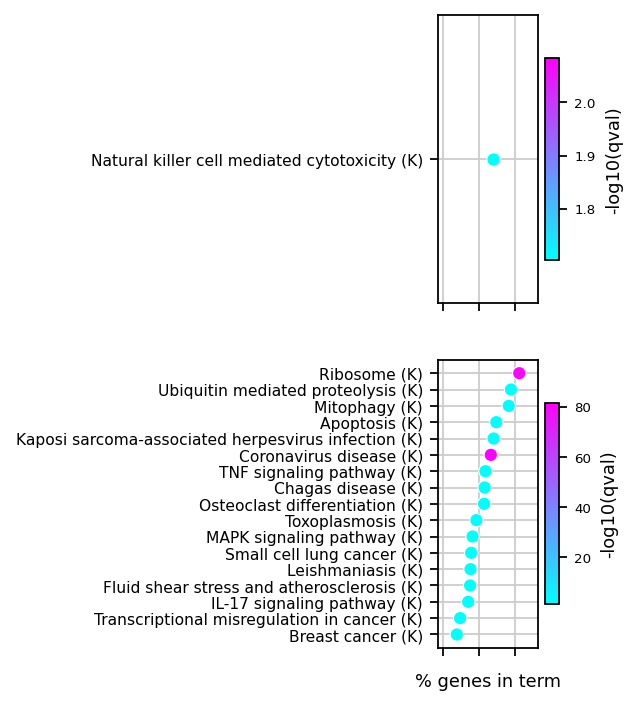

In [25]:
# UP regulated
df2plot = OUTPUT_PATHWAY_up.sort_values('percent', ascending=False).reset_index()
df2plot['-log10(qval)'] = -np.log10(df2plot['qval'])
norm_up = plt.Normalize(df2plot['-log10(qval)'].min(), df2plot['-log10(qval)'].max())
sm_up = plt.cm.ScalarMappable(cmap="cool", norm=norm_up)
sm_up.set_array([])

fig, ax = plt.subplots(2,1, figsize=(1,5.2), sharex=True)

ax[0].grid(True)
g = sns.scatterplot(data=df2plot, x='percent', y='term_clean',
                    hue='-log10(qval)', palette='cool', ax=ax[0], zorder=3,
                    hue_norm=(df2plot['-log10(qval)'].min(), df2plot['-log10(qval)'].max()),
                    linewidth=0.5, legend=False)

# Down regulated
df2plot = OUTPUT_PATHWAY_dn.sort_values('percent', ascending=False).reset_index()
df2plot['-log10(qval)'] = -np.log10(df2plot['qval'])
norm_dn = plt.Normalize(df2plot['-log10(qval)'].min(), df2plot['-log10(qval)'].max())
sm_dn = plt.cm.ScalarMappable(cmap="cool", norm=norm_dn)
sm_dn.set_array([])

ax[1].grid(True)
g = sns.scatterplot(data=df2plot, x='percent', y='term_clean',
                    hue='-log10(qval)', palette='cool', ax=ax[1], zorder=3,
                    hue_norm=(df2plot['-log10(qval)'].min(), df2plot['-log10(qval)'].max()),
                    linewidth=0.5, legend=False)


delta = 0.1
xlim = (np.min([ax[0].get_xlim()[0], ax[1].get_xlim()[0]]), np.max([ax[0].get_xlim()[1], ax[1].get_xlim()[1]]))
ax[1].set_xlim(np.floor(np.min(xlim[0])*100)/100 - delta,np.ceil(np.max(xlim[1])*100)/100 + delta)
for a in ax:
    a.set_yticklabels(a.get_yticklabels(), fontsize=7); #7
    a.set_yticklabels(a.get_yticklabels(), fontsize=7); #7
    a.set_ylabel('', fontsize=6);
    a.set_xticklabels(a.get_xticklabels(), fontsize=7); #7
    a.set_xlabel('% genes in term', fontsize=8);

cbar = fig.colorbar(sm_up, label='-log10(qval)', shrink=0.7, aspect=20*0.7, ax=ax[0])
cbar.ax.tick_params(labelsize=6) 
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), size=8) ;

cbar = fig.colorbar(sm_dn, label='-log10(qval)', shrink=0.7, aspect=20*0.7, ax=ax[1])
cbar.ax.tick_params(labelsize=6) 
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), size=8) ;

plt.tight_layout()
plt.savefig('./figures/T21_hypergeo_nk_cells.pdf', dpi=300)